# Table of Contents
 <p><div class="lev1 toc-item"><a href="#TF-intro" data-toc-modified-id="TF-intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TF intro</a></div><div class="lev1 toc-item"><a href="#MLP-on-MNIST" data-toc-modified-id="MLP-on-MNIST-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MLP on MNIST</a></div><div class="lev1 toc-item"><a href="#VAEs!" data-toc-modified-id="VAEs!-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>VAEs!</a></div>

# TF intro

This guide assumes you can read through basic Python code or use your google skills to catch up on that as needed. We begin by understanding how tensorflow works. The key point to remember is that all the tensorflow computation happens in a graph, and all that you get to do in python is to manipulate and run that graph. This creates a programming paradigm that looks a lot like python but is actually quite different. We begin with a simple logistic regression example. 

In [1]:
import tensorflow as tf
import numpy as np

n_obs = 1000
n_features = 5

x_ph = tf.placeholder(shape=(n_obs, n_features), name="x_ph", dtype=tf.float32)
beta_init = np.random.normal(size=(n_features, 1))
beta_hat = tf.Variable(beta_init, dtype=tf.float32, name="beta_hat")
y_hat = tf.nn.sigmoid(tf.matmul(x_ph, beta_hat), name="yhat")

We can visualize thie graph, and then explain what the different parts are: 

This code is a modification from the DeepDream notebook. There is more visualization / exploration that can be done using tensorboard, which is the tool this uses. 

In [2]:
# TensorFlow Graph visualizer code
# https://stackoverflow.com/questions/41388673/visualizing-a-tensorflow-graph-in-jupyter-doesnt-work
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:800px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:800px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [3]:
show_graph(tf.get_default_graph().as_graph_def())

What we do in tensorflow is construct graphs like this, and then evaluate nodes. Each graph node is associated with some code. When we evaluate a node like `y_hat`, tensorflow figures out what nodes it depends on, evaluates all of those nodes, and then evaluates `y_hat`. In this graph, there are three types of nodes (`Tensor`s), a `Variable`, a `placeholder`, and a vanilla `Tensor` that is none of the above. Tensors have no state: they are computable from the rest of the graph. Variables have state (they're the only thing we can optimize / save / load). Placeholders are not computable and don't have state: we must feed values into them. We can also feed values into other tensors, but TF will explicitly complain if we fail to feed a value into a placeholder. 

Our python objects like `beta_hat` are references to the TF graph nodes, not the nodes themselves (i.e. copying the python object does not dupliate the graph node). 

To evaluate a graph we need to associate it with a session, and then either a tensor's `eval` method or the session's `run` method. The difference is that we can `run` multiple tensors together, which might be useful if they share dependencies. 

Now we define the loss, generate synth data, and optimize: 

In [4]:
from scipy.special import expit as logistic

true_beta = np.random.normal(size=(n_features, 1))
x = np.random.normal(size=(n_obs, n_features))
y = np.random.binomial(n=1, p=logistic(x @ true_beta))

y_ph = tf.placeholder(shape=(n_obs, 1), name="y_ph", dtype=tf.float32)

logistic_loss = -tf.reduce_sum(y_ph * tf.log(1e-10 + y_hat)+ (1-y_ph) * tf.log(1e-10 + 1 - y_hat))

# if we needed the gradients for some reason, e.g. to pass to an external optimizier or to plot
# grads = tf.gradients(logistic_loss, beta_hat)

# create the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0005)

# this is the long way of doing it
# grads_and_vars = optimizer.compute_gradients(logistic_loss, beta_hat)
# optionally, modify gradients here (e.g. threshold)
# minimize_op = optimizer.apply_gradients(grads_and_vars)

# the short way
minimize_op = optimizer.minimize(logistic_loss) # by default, minimize w.r.t. all variables

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(2500):
    if i % 100 == 0:
        l = logistic_loss.eval(session=sess, feed_dict={x_ph:x, y_ph:y})
        print("Iter %i, loss %f" % (i, l))
    sess.run(minimize_op, feed_dict={x_ph:x, y_ph:y})

accuracy = np.average(tf.equal(tf.round(y_hat), y_ph).eval(session=sess, feed_dict={x_ph:x, y_ph:y}))
print(accuracy)

Iter 0, loss 1643.349365
Iter 100, loss 322.295319
Iter 200, loss 318.575439
Iter 300, loss 318.227783
Iter 400, loss 318.185028
Iter 500, loss 318.179443
Iter 600, loss 318.178589
Iter 700, loss 318.178467
Iter 800, loss 318.178528
Iter 900, loss 318.178467
Iter 1000, loss 318.178467
Iter 1100, loss 318.178467
Iter 1200, loss 318.178467
Iter 1300, loss 318.178467
Iter 1400, loss 318.178467
Iter 1500, loss 318.178467
Iter 1600, loss 318.178467
Iter 1700, loss 318.178467
Iter 1800, loss 318.178467
Iter 1900, loss 318.178467
Iter 2000, loss 318.178467
Iter 2100, loss 318.178467
Iter 2200, loss 318.178467
Iter 2300, loss 318.178467
Iter 2400, loss 318.178467
0.859


In [5]:
# another optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
minimize_op = optimizer.minimize(logistic_loss) # by default, minimize w.r.t. all variables

sess.run(tf.global_variables_initializer())
for i in range(1000):
    if i % 100 == 0:
        l = logistic_loss.eval(session=sess, feed_dict={x_ph:x, y_ph:y})
        print("Iter %i, loss %f" % (i, l))
    sess.run(minimize_op, feed_dict={x_ph:x, y_ph:y})

accuracy = np.average(tf.equal(tf.round(y_hat), y_ph).eval(session=sess, feed_dict={x_ph:x, y_ph:y}))
print(accuracy)

Iter 0, loss 1643.349365
Iter 100, loss 800.760925
Iter 200, loss 493.412537
Iter 300, loss 391.814850
Iter 400, loss 355.020020
Iter 500, loss 338.317505
Iter 600, loss 329.631958
Iter 700, loss 324.791870
Iter 800, loss 322.002808
Iter 900, loss 320.373474
0.863


One more tutorial point is on how to print things. Since a tensor only has a value when the graph is executed, inspecting things is trickier than usual. The `Print` op returns the same op as its input, but prints as a side-effect. This means we need to inject the op into the graph. Unfortunately, the print happens on the C++ end, so we will see the logging messages in the jupyter server log (or in a shell). 

In [6]:
logistic_loss_with_print = tf.Print(input_=logistic_loss, data=[x, logistic_loss])

_ = logistic_loss_with_print.eval(session=sess, feed_dict={x_ph:x, y_ph:y})

# MLP on MNIST

Now we build some neural network building blocks we will reuse for VAEs. 

In [7]:
from tensorflow.examples.tutorials.mnist import input_data

global_dtype = tf.float32
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
input_size = mnist.train.images.shape[1]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Define our neural network building blocks. 

In [8]:
def _dense_mlp_layer(x, input_size, out_size, nonlinearity=tf.nn.softmax, name_prefix=""):
    w_init = tf.truncated_normal(shape=[input_size, out_size], stddev=0.001)
    b_init = tf.ones(shape=[out_size]) * 0.1
    W = tf.Variable(w_init, name="%s_W" % name_prefix)
    b = tf.Variable(b_init, name="%s_b" % name_prefix)
    out = nonlinearity(tf.matmul(x, W) + b)
    return out, [W, b]

def _mlp(x, n_layers, units_per_layer, input_size, out_size, nonlinearity=tf.tanh):
    train_vars = []

    x, v = _dense_mlp_layer(x, input_size, units_per_layer, nonlinearity, name_prefix="into_hidden")
    train_vars.extend(v)
    # exploit the fact that repeatedly calling the same TF function creates multiple ops. 
    # no need to hang onto the intermediate layer handles (though we can get them back if we need them)
    for l in range(n_layers-1):
        x, v = _dense_mlp_layer(x, units_per_layer, units_per_layer, nonlinearity, name_prefix="hidden")
        train_vars.extend(v)

    x, v = _dense_mlp_layer(x, units_per_layer, out_size, nonlinearity, name_prefix="readout")
    train_vars.extend(v)
    return x, train_vars

Now we construct the graph. The graph and scope boilerplate makes our life easier as far as visualization and debugging is concerned. We can visualize/run only this graph and not the graph for logistic regression (above). 

In [9]:
mlp_graph = tf.Graph()

with mlp_graph.as_default():
    with tf.name_scope("Feedforward_Net"):
        x = tf.placeholder(shape=[None, input_size], dtype=global_dtype, name='x')
        y = tf.placeholder(shape=[None, 10], dtype=global_dtype, name='y')
        y_hat, mlp_test_vars = _mlp(x, n_layers=2, units_per_layer=30, input_size=784, out_size=10)

    with tf.name_scope("Opt_and_loss"):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat))
        # learning rates are much smaller for optimizers like Adam and RMSProp
        train_step_mlptest = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)

    with tf.name_scope("Support_stuff"):
        init = tf.global_variables_initializer()
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_hat,1))
        mlp_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

We visualize our graph: 

In [10]:
show_graph(mlp_graph.as_graph_def())

Next we create a session, initialize our variables, and train the network: 

Test accuracy: 0.928500


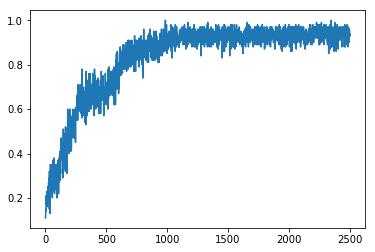

In [11]:
sess = tf.Session(graph=mlp_graph)
sess.run(init)
train_steps = 2500

acc = np.zeros(train_steps)

# create this op outside of the loop so we don't create it 5000 times
for i in range(train_steps):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    acc[i] = mlp_acc.eval(session = sess, feed_dict = {x: batch_xs, y: batch_ys})
    sess.run(train_step_mlptest, feed_dict={x: batch_xs, y: batch_ys})

test_acc = mlp_acc.eval(session=sess, feed_dict={x: mnist.test.images, y: mnist.test.labels})
print("Test accuracy: %f" % test_acc)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(acc)

# VAEs! 
$$
\DeclareMathOperator{\Tr}{Tr}
\newcommand{\trp}{{^\top}} % transpose
\newcommand{\trace}{\text{Trace}} % trace
\newcommand{\inv}{^{-1}}
\newcommand{\mb}{\mathbf{b}}
\newcommand{\M}{\mathbf{M}}
\newcommand{\G}{\mathbf{G}}
\newcommand{\A}{\mathbf{A}}
\newcommand{\R}{\mathbf{R}}
\renewcommand{\S}{\mathbf{S}}
\newcommand{\B}{\mathbf{B}}
\newcommand{\Q}{\mathbf{Q}}
\newcommand{\mH}{\mathbf{H}}
\newcommand{\U}{\mathbf{U}}
\newcommand{\mL}{\mathbf{L}}
\newcommand{\diag}{\mathrm{diag}}
\newcommand{\etr}{\mathrm{etr}}
\renewcommand{\H}{\mathbf{H}}
\newcommand{\vecop}{\mathrm{vec}}
\newcommand{\I}{\mathbf{I}}
\newcommand{\X}{\mathbf{X}_{ij}}
\newcommand{\Y}{\mathbf{Y}_{jk}}
\newcommand{\Z}{\mathbf{Z}_{ik}}
$$

In our generative model, we would like to estimate the density of some complicated probability density $\log P_{\theta}(X)$. This is slightly odd notation but seems standard in these papers: it says that $X$ is a random variable but $\theta$ are parameters. To do this, we will write it as follows:

$$
\log P_{\theta}(X) =  \log P_{\theta}(X,Z) - \log P_{\theta}(Z\mid X) 
$$

This is just the definition of marginal probability. Next, we add/subtract $\log Q_{\phi}(Z\mid X)$ which sums to 0: 

$$
\log P_{\theta}(X) =  \log P_{\theta}(X,Z) - \log P_{\theta}(Z\mid X) - \log Q_{\phi}(Z\mid X) + \log Q_{\phi}(Z\mid X)
$$

We take expectation of both sides. Note that this expectation has to be w.r.t. the conditional distribution $Q(Z\mid X)$ for the rest of this to work properly: 

$$
\mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X) =  \mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X,Z) - \mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(Z\mid X) - \mathbb{E}_{Q(Z\mid X)}\log Q_{\phi}(Z\mid X) + \mathbb{E}_{Q(Z\mid X)}\log Q_{\phi}(Z\mid X)
$$

Since the LHS is independent of Z, that expectation just goes away. We rearrange the terms and realize we ended up with the evidence lower bound (ELBO) and a KL divergence: 

$$
\begin{align}
\log P_{\theta}(X) =&  \mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X,Z) - \mathbb{E}_{Q(Z\mid X)}\log Q_{\phi}(Z\mid X) + \mathbb{E}_{Q(Z\mid X)}\log Q_{\phi}(Z\mid X)- \mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(Z\mid X) \\
  =&  \mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X,Z) - \mathbb{E}_{Q(Z\mid X)}\log Q_{\phi}(Z\mid X) + \int_Z Q_{\phi}(Z\mid X)\log Q_{\phi}(Z\mid X)- \int_Z Q_{\phi}(Z\mid X)\log P_{\theta}(Z\mid X) \\
=&  \mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X,Z) +\mathbb{E}_{Q(Z\mid X)}\log Q_{\phi}(Z\mid X) - \int_Z Q_{\phi}(Z\mid X)\log \frac{Q_{\phi}(Z\mid X)}{P_{\theta}(Z\mid X)} \\
=&  \mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X,Z) + \mathbb{E}_{Q(Z\mid X)}\log Q_{\phi}(Z\mid X) -\mathcal{D}_{KL}(Q_{\theta}(Z\mid X)||  P_{\phi}(Z\mid X)) 
\end{align}
$$

The ELBO is a lower bound because KL divergence is greater than equal to 0. So if we want to maximize the LHS, we can choose to either minimize the KL divergence, or maximize the ELBO.  We would rather do the former, because the KL divergence contains the posterior $P(Z\mid X)$ and if we knew how to do that, we wouldn't be going through this hassle. The nice thing is, since this holds for any $Q$ and any $Z$ we can define both distributions to be as nice as we like. So we're going to say that the likelihood $P_{\theta}(X,Z)$, prior $P_{\theta}(Z)$ and approximate posterior $Q_{\theta}(X,Z)$ are all gaussian. We pick the easiest possible marginal distribution over $Q(Z)$, an identity-covariance gaussian: 

$$
\begin{align}
P_{\theta}(X\mid Z) :=& \mathcal{N}(a(Z,\theta), b(Z,\theta)b(Z,\theta)\trp) \\
Q_{\phi}(Z\mid X):=&\mathcal{N}(f(X,\phi),g(X,\phi)g(X,\phi)^{\intercal})\\
P_{\theta}(Z) :=& \mathcal{N}(0,\mathbf{I})
\end{align}
$$

The distributions $P_{\theta}(X\mid Z)$ and $Q_{\phi}(Z\mid X)$ are parameterized by mean and covariance-square-root functions $a,b,f,g$ which we leave unspecified for now. In practice for VAEs people use the equivalent of a mean-field assumption, which means that the covariance functions will just return SDs/variances, but I'd like to write the reparameterization trick in general form. We can additionally rewrite the expression to get a second KL divergence: 

$$
\begin{align}
\log P_{\theta}(X) =& \mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X\mid Z) + \mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(Z) + \mathbb{E}_{Q(Z\mid X)}\log Q_{\phi}(Z\mid X)-\mathcal{D}_{KL}(Q_{\theta}(Z\mid X)||  P_{\phi}(Z\mid X)) \\
=&\mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X\mid Z) + \mathcal{D}_{KL}( Q_{\phi}(Z\mid X)||P_{\theta}(Z)) - \mathcal{D}_{KL}(Q_{\theta}(Z\mid X)||  P_{\phi}(Z\mid X))
\end{align}
$$

Conveniently, the KL divergence between two gaussians (the prior and approximate posterior) is analytic. What remains is the expectation $\mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X\mid Z)$, which we can compute from its empirical, sample-based mean: 

$$
\mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X\mid Z) = \int Q_{\phi}(Z\mid X)\log P_{\theta}(X|Z)d Q \approx \frac{1}{N} \sum \log P_{\theta}(X|Z) Z_i, \\\
Z_i\sim\mathcal{N}(f(X,\phi),g(X,\phi)g(X,\phi)\trp)
$$

The naive gradient estimator here has very high variance according to the VAE paper, though it is used in Blei, Jordan and Paisley 2012 (ICML):

$$
\nabla_{\phi}\mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X\mid Z) \approx \frac{1}{N} \sum \nabla_{\phi}\log P_{\theta}(X|Z) Z_i
$$

What the VAE paper does instead is apply the reparameterization trick:  

\begin{align}
\epsilon&\sim\mathcal{N}(0, \I)\\
Z &= f(X,\phi) + g(X,\phi)\epsilon\\
\mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X\mid Z)  &\approx \frac{1}{N} \sum \log P_{\theta}(X|Z)(f(X,\phi) + g(X,\phi)\epsilon)\\
\nabla_{\phi}\mathbb{E}_{Q(Z\mid X)}\log P_{\theta}(X\mid Z)  &\approx \frac{1}{N} \sum \nabla_{\phi}\log P_{\theta}(X|Z)(f(X,\phi) + g(X,\phi)\epsilon)
\end{align}

Now let's see if we can implement it using tensorflow. We begin by sanity-checking a basic MLP and then go to VAEs. First, import some things we'll need and download MNIST: 

In [52]:
from tensorflow.examples.tutorials.mnist import input_data

encoder_depth = 2
decoder_depth = 2
encoder_units = 200
decoder_units = 200
latent_size = 2 # for visualization tricks
global_dtype = tf.float32
minibatch_size = 100
input_size = mnist.train.images.shape[1]
train_steps = mnist.train.num_examples // minibatch_size
encoder_nonlinearity = tf.nn.tanh
decoder_nonlinearity = tf.nn.tanh
n_epochs = 5

Construct the graph: 

In [57]:
vae_graph = tf.Graph()

with vae_graph.as_default():

    with tf.name_scope("Encoder_Q"):

        x = tf.placeholder(shape=[None, input_size], dtype=global_dtype, name='x')
        q_network, q_mu_vars = _mlp(x, n_layers=encoder_depth, units_per_layer=encoder_units, input_size=input_size, out_size=encoder_units, nonlinearity=encoder_nonlinearity)
        w_mu = tf.Variable(tf.truncated_normal(shape=[encoder_units, latent_size], stddev=0.1), name="w_mu")
        w_logsig = tf.Variable(tf.truncated_normal(shape=[encoder_units, latent_size], stddev=0.1), name="w_logsig")
        b_mu = tf.Variable(tf.truncated_normal(shape=[latent_size], stddev=0.1), name="b_mu")
        b_logsig = tf.Variable(tf.truncated_normal(shape=[latent_size], stddev=0.1), name="b_logsig")
        q_mu = tf.matmul(q_network, w_mu) + b_mu
        q_logsigma = tf.matmul(q_network, w_logsig) + b_logsig
        epsilon = tf.random_normal([tf.shape(x)[0], latent_size])
        z = q_mu + tf.sqrt(tf.exp(q_logsigma)) * epsilon

    with tf.name_scope("Decoder_P"):
        # need to be in 0..1 for x-entropy to work and not all nonlinearities give us this, hence another readout
        p_mu_raw, p_mu_vars = _mlp(z, n_layers=decoder_depth, units_per_layer=decoder_units, input_size=latent_size,  out_size=input_size, nonlinearity=decoder_nonlinearity)
        w_p_mu = tf.Variable(tf.truncated_normal(shape=[input_size, input_size], stddev=0.1))
        p_mu = tf.nn.sigmoid(tf.matmul(p_mu_raw, w_p_mu)) 

    with tf.name_scope("Opt_and_loss"):
        kld = 0.5 * tf.reduce_sum(1 + q_logsigma - tf.square(q_mu) - tf.exp(q_logsigma), 1)
        ll = tf.reduce_sum(x * tf.log(1e-10 + p_mu)+ (1-x) * tf.log(1e-10 + 1 - p_mu), 1)
        elbo = tf.reduce_mean(ll + kld)
        minimize_op = tf.train.AdamOptimizer(0.005).minimize(-elbo)

    with tf.name_scope("Support_stuff"):
        init = tf.global_variables_initializer()
    

In [14]:
show_graph(vae_graph.as_graph_def())

Now we run and visualize: 

In [58]:
sess = tf.Session(graph=vae_graph)
sess.run(init)

elbo_log = np.zeros(n_epochs * train_steps)

for i in range(n_epochs):
    for j in range(train_steps):
        batch_xs, batch_ys = mnist.train.next_batch(minibatch_size)
        sess.run(minimize_op, feed_dict={x: batch_xs})
        elbo_log[i*train_steps + j] = elbo.eval(session=sess, feed_dict={x: batch_xs})
        if j % 100 == 0:
            print("Epoch %i, step %i: average elbo= %f" % (i, j, elbo_log[i*train_steps + j]))

Epoch 0, step 0: average elbo=-417.898254
Epoch 0, step 100: average elbo=-197.902847
Epoch 0, step 200: average elbo=-202.920624
Epoch 0, step 300: average elbo=-188.766678
Epoch 0, step 400: average elbo=-192.972076
Epoch 0, step 500: average elbo=-181.174332
Epoch 1, step 0: average elbo=-186.935974
Epoch 1, step 100: average elbo=-178.752457
Epoch 1, step 200: average elbo=-180.496841
Epoch 1, step 300: average elbo=-184.784531
Epoch 1, step 400: average elbo=-176.757690
Epoch 1, step 500: average elbo=-184.351074
Epoch 2, step 0: average elbo=-174.459457
Epoch 2, step 100: average elbo=-179.125412
Epoch 2, step 200: average elbo=-172.297867
Epoch 2, step 300: average elbo=-177.168320
Epoch 2, step 400: average elbo=-171.194260
Epoch 2, step 500: average elbo=-178.512268
Epoch 3, step 0: average elbo=-176.119507
Epoch 3, step 100: average elbo=-174.827301
Epoch 3, step 200: average elbo=-176.470078
Epoch 3, step 300: average elbo=-171.976959
Epoch 3, step 400: average elbo=-172.511

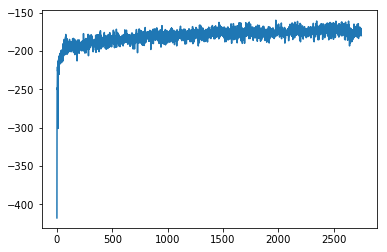

In [59]:
plt.plot(elbo_log)

Now we compare samples to reconstruction. These won't be great with a 2d latent space, but it allows us to make the neat morphing letters figure . 

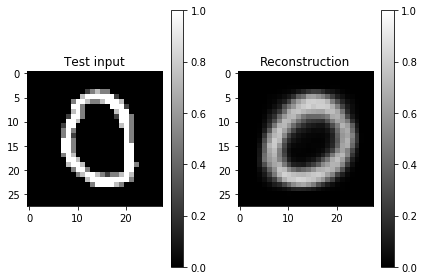

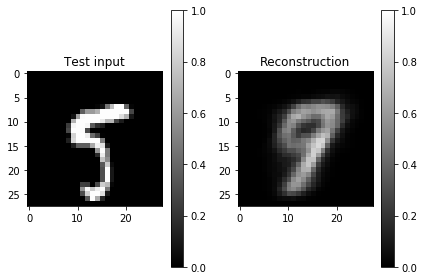

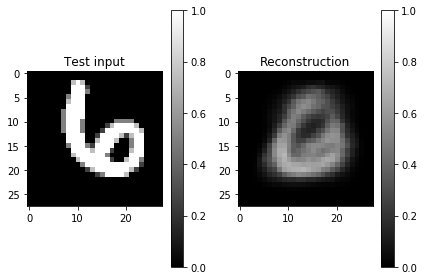

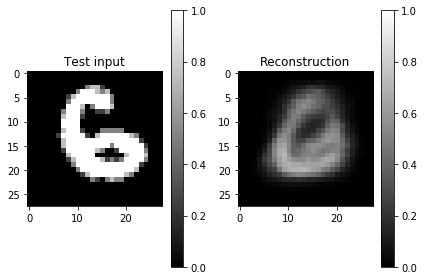

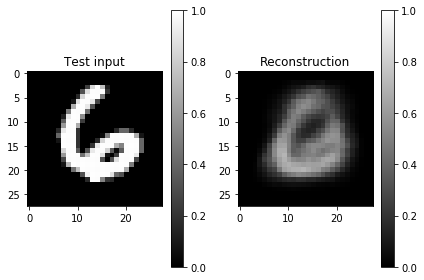

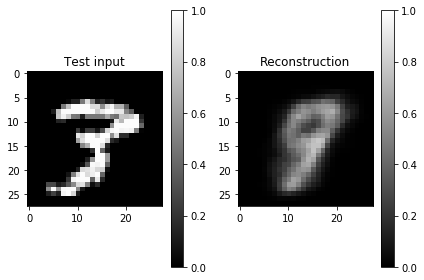

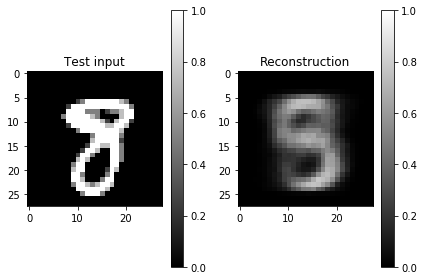

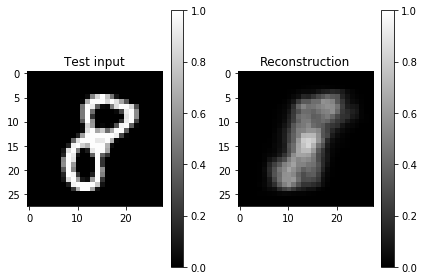

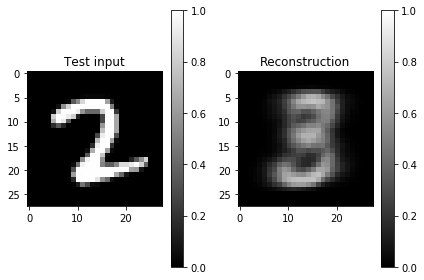

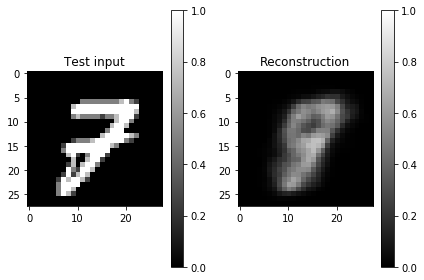

In [62]:
x_sample, _ = mnist.test.next_batch(10)
# zero out the noise
x_reconstruct = p_mu.eval(session=sess, feed_dict={x:x_sample, epsilon:np.zeros(shape=(10,2))})
for i in range(10):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    plt.tight_layout()

Generate some simulated numbers! 

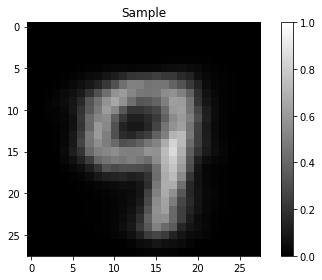

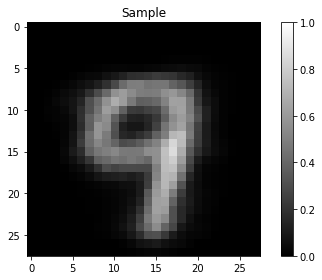

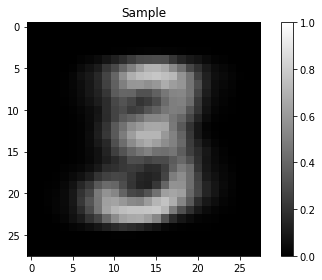

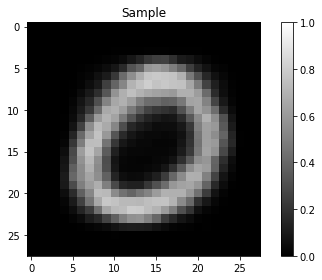

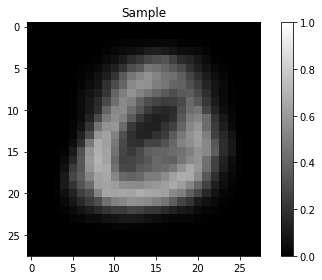

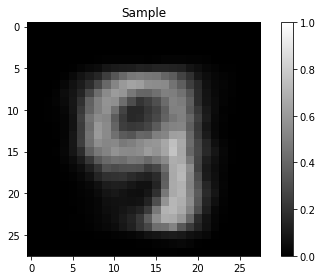

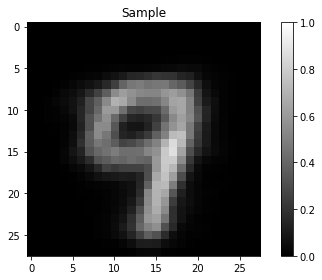

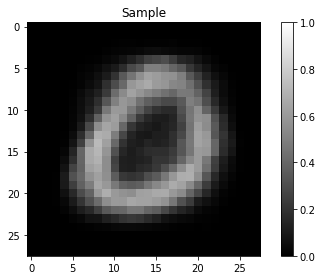

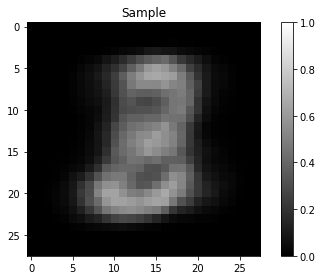

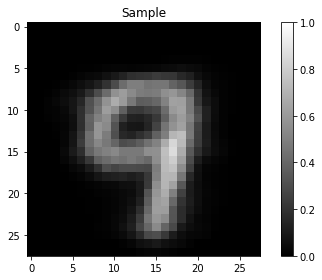

In [65]:
z_sim = np.random.normal(size=(10, latent_size))
simulated_x = p_mu.eval(session=sess, feed_dict={z:z_sim})
for i in range(10):    
    plt.figure()
    plt.imshow(simulated_x[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Sample")
    plt.colorbar()
    plt.tight_layout()

Now make the grid figure where we can visualize the 2d latent space: 

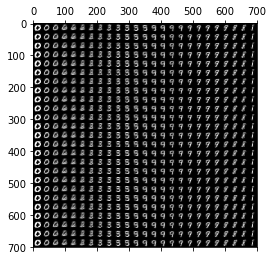

In [69]:
from scipy.stats import norm

gridsize = 25

spacing = norm.ppf(np.linspace(0.0001, 0.999, gridsize))
z_grid = np.r_[np.meshgrid(spacing, spacing)].reshape(2, -1)

x_grid = p_mu.eval(session=sess, feed_dict={z:z_grid.T})
x_grid = x_grid.reshape(gridsize, gridsize, 28, 28).swapaxes(1,2).reshape(gridsize*28, gridsize*28)

plt.matshow(x_grid, cmap="gray")